In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
dirctory = os.getcwd()

train = pd.read_csv(str(dirctory)+"/kaggle_house_pred_train.csv")
test = pd.read_csv(str(dirctory)+"/kaggle_house_pred_test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))

In [3]:
print(train.shape)
print(test.shape)
train.head()

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Preprocess

In [4]:
numeric_feats = all_X.dtypes[all_X.dtypes != "object"].index
print(numeric_feats)
all_X[numeric_feats] = all_X[numeric_feats].apply(lambda x: (x - x.mean())/(x.std()))  #normalize

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


In [5]:
all_X = pd.get_dummies(all_X, dummy_na=True) #turn category values into numerical dummy variables

In [6]:
all_X = all_X.fillna(all_X.mean()) #intersting...this seems to fill each column with local mean!
#print(all_X.mean())

In [7]:
num_train = train.shape[0]

X_train = all_X[:num_train].as_matrix()
X_test = all_X[num_train:].as_matrix()
y_train = train.SalePrice.as_matrix()

In [8]:
from mxnet import ndarray as nd
from mxnet import autograd
from mxnet import gluon

X_train = nd.array(X_train)
y_train = nd.array(y_train)
y_train.reshape((num_train, 1))

X_test = nd.array(X_test)

In [9]:
#define loss function
square_loss = gluon.loss.L2Loss()

In [10]:
def get_rmse_log(net, X_train, y_train):
    num_train = X_train.shape[0]
    clipped_preds = nd.clip(net(X_train), 1, float('inf'))
    return np.sqrt(2 * nd.sum(square_loss(nd.log(clipped_preds), nd.log(y_train))).asscalar() / num_train)



In [11]:
def get_net():
    net = gluon.nn.Sequential()
    with net.name_scope():
        net.add(gluon.nn.Dense(1))
    net.initialize()
    return net

In [12]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(net, X_train, y_train, X_test, y_test, epochs,
          verbose_epoch, learning_rate, weight_decay):
    train_loss = []
    if X_test is not None:
        test_loss = []
    batch_size = 100
    dataset_train = gluon.data.ArrayDataset(X_train, y_train)
    data_iter_train = gluon.data.DataLoader(
        dataset_train, batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(), 'adam',
                            {'learning_rate': learning_rate,
                             'wd': weight_decay})
    net.collect_params().initialize(force_reinit=True)
    for epoch in range(epochs):
        for data, label in data_iter_train:
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            cur_train_loss = get_rmse_log(net, X_train, y_train)
        #if epoch > verbose_epoch:
            #print("Epoch %d, train loss: %f" % (epoch, cur_train_loss))
        #train_loss.append(cur_train_loss)
        if X_test is not None:
            cur_test_loss = get_rmse_log(net, X_test, y_test)
            test_loss.append(cur_test_loss)
    plt.plot(train_loss)
    plt.legend(['train'])
    if X_test is not None:
        plt.plot(test_loss)
        plt.legend(['train','test'])
    #plt.show()
    if X_test is not None:
        return cur_train_loss, cur_test_loss
    else:
        return cur_train_loss

In [13]:
def k_fold_cross_valid(k, epochs, verbose_epoch, X_train, y_train,
                       learning_rate, weight_decay):
    assert k > 1
    fold_size = X_train.shape[0] // k
    train_loss_sum = 0.0
    test_loss_sum = 0.0
    for test_i in range(k):
        X_val_test = X_train[test_i * fold_size: (test_i + 1) * fold_size, :]
        y_val_test = y_train[test_i * fold_size: (test_i + 1) * fold_size]

        val_train_defined = False
        for i in range(k):
            if i != test_i:
                X_cur_fold = X_train[i * fold_size: (i + 1) * fold_size, :]
                y_cur_fold = y_train[i * fold_size: (i + 1) * fold_size]
                if not val_train_defined:
                    X_val_train = X_cur_fold
                    y_val_train = y_cur_fold
                    val_train_defined = True
                else:
                    X_val_train = nd.concat(X_val_train, X_cur_fold, dim=0)
                    y_val_train = nd.concat(y_val_train, y_cur_fold, dim=0)
        net = get_net()
        train_loss, test_loss = train(
            net, X_val_train, y_val_train, X_val_test, y_val_test,
            epochs, verbose_epoch, learning_rate, weight_decay)
        train_loss_sum += train_loss
        #print("Test loss: %f" % test_loss)
        test_loss_sum += test_loss
    return train_loss_sum / k, test_loss_sum / k

In [14]:
all_X.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.29303,...,0,1,0,0,0,0,0,1,0,0
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.29303,...,0,1,0,0,0,0,0,1,0,0
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.29303,...,0,1,0,0,0,0,0,1,0,0
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.29303,...,0,1,0,1,0,0,0,0,0,0
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.29303,...,0,1,0,0,0,0,0,1,0,0


5-fold validation: Avg train loss: 0.157907, Avg test loss: 0.166307


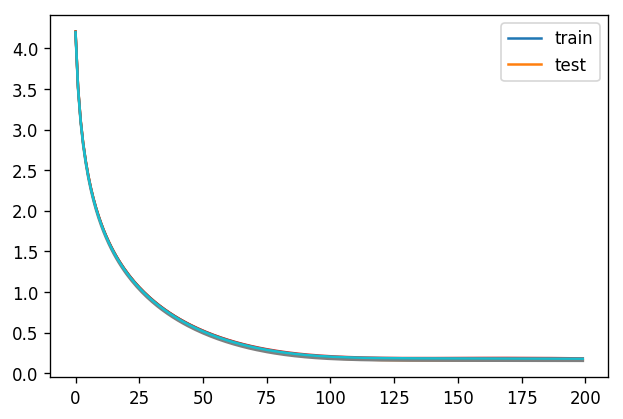

In [15]:
k = 5
epochs = 200
verbose_epoch = 95
learning_rate = 5
weight_decay = 0.0


train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                           y_train, learning_rate, weight_decay)
print("%d-fold validation: Avg train loss: %f, Avg test loss: %f" %
      (k, train_loss, test_loss))

paramters: k = 4, epochs = 150, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.238118, Avg test loss: 0.241871 

paramters: k = 4, epochs = 150, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.242017, Avg test loss: 0.245786 

paramters: k = 4, epochs = 150, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.238088, Avg test loss: 0.241790 

paramters: k = 4, epochs = 150, verbose_epoch = 90, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.519574, Avg test loss: 0.521705 

paramters: k = 4, epochs = 150, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.246167, Avg test loss: 0.249961 

paramters: k = 4, epochs = 150, verbose_epoch = 90, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.176829, Avg test loss: 0.180885 

paramters: k = 4, epochs = 150, verbose_epoch

paramters: k = 4, epochs = 150, verbose_epoch = 93, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.177017, Avg test loss: 0.180964 

paramters: k = 4, epochs = 150, verbose_epoch = 93, learning_rate = 4, weight_decay = 15
4-fold validation: Avg train loss: 0.462064, Avg test loss: 0.464065 

paramters: k = 4, epochs = 150, verbose_epoch = 93, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.187516, Avg test loss: 0.191499 

paramters: k = 4, epochs = 150, verbose_epoch = 93, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.165701, Avg test loss: 0.170857 

paramters: k = 4, epochs = 150, verbose_epoch = 93, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.175393, Avg test loss: 0.181264 

paramters: k = 4, epochs = 150, verbose_epoch = 93, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.165653, Avg test loss: 0.170702 

paramters: k = 4, epochs = 150, verbose_epoch

paramters: k = 4, epochs = 150, verbose_epoch = 96, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.282572, Avg test loss: 0.274547 

paramters: k = 4, epochs = 150, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.238121, Avg test loss: 0.241834 

paramters: k = 4, epochs = 150, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.242018, Avg test loss: 0.245804 

paramters: k = 4, epochs = 150, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.238101, Avg test loss: 0.241749 

paramters: k = 4, epochs = 150, verbose_epoch = 97, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.519690, Avg test loss: 0.521836 

paramters: k = 4, epochs = 150, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.246198, Avg test loss: 0.250090 

paramters: k = 4, epochs = 150, verbose_epoch

paramters: k = 4, epochs = 150, verbose_epoch = 100, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.181527, Avg test loss: 0.185560 

paramters: k = 4, epochs = 150, verbose_epoch = 100, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.177037, Avg test loss: 0.181033 

paramters: k = 4, epochs = 150, verbose_epoch = 100, learning_rate = 4, weight_decay = 15
4-fold validation: Avg train loss: 0.462073, Avg test loss: 0.464085 

paramters: k = 4, epochs = 150, verbose_epoch = 100, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.187536, Avg test loss: 0.191740 

paramters: k = 4, epochs = 150, verbose_epoch = 100, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.165661, Avg test loss: 0.170720 

paramters: k = 4, epochs = 150, verbose_epoch = 100, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.175200, Avg test loss: 0.181293 

paramters: k = 4, epochs = 150, verbose

paramters: k = 4, epochs = 150, verbose_epoch = 103, learning_rate = 5, weight_decay = 15
4-fold validation: Avg train loss: 0.440658, Avg test loss: 0.442592 

paramters: k = 4, epochs = 150, verbose_epoch = 103, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.279356, Avg test loss: 0.274597 

paramters: k = 4, epochs = 150, verbose_epoch = 104, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.238095, Avg test loss: 0.241790 

paramters: k = 4, epochs = 150, verbose_epoch = 104, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.242042, Avg test loss: 0.245766 

paramters: k = 4, epochs = 150, verbose_epoch = 104, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.238170, Avg test loss: 0.241841 

paramters: k = 4, epochs = 150, verbose_epoch = 104, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.519630, Avg test loss: 0.521762 

paramters: k = 4, epochs = 150, verbos

paramters: k = 4, epochs = 200, verbose_epoch = 92, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.164087, Avg test loss: 0.169922 

paramters: k = 4, epochs = 200, verbose_epoch = 92, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.180000, Avg test loss: 0.192867 

paramters: k = 4, epochs = 200, verbose_epoch = 92, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.164044, Avg test loss: 0.169972 

paramters: k = 4, epochs = 200, verbose_epoch = 92, learning_rate = 4, weight_decay = 15
4-fold validation: Avg train loss: 0.435280, Avg test loss: 0.437187 

paramters: k = 4, epochs = 200, verbose_epoch = 92, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.314597, Avg test loss: 0.274280 

paramters: k = 4, epochs = 200, verbose_epoch = 92, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.160260, Avg test loss: 0.169007 

paramters: k = 4, epochs = 200, verbose_epoch

paramters: k = 4, epochs = 200, verbose_epoch = 95, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.160139, Avg test loss: 0.168833 

paramters: k = 4, epochs = 200, verbose_epoch = 95, learning_rate = 5, weight_decay = 15
4-fold validation: Avg train loss: 0.429095, Avg test loss: 0.430996 

paramters: k = 4, epochs = 200, verbose_epoch = 95, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.314689, Avg test loss: 0.275343 

paramters: k = 4, epochs = 200, verbose_epoch = 96, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.174778, Avg test loss: 0.178775 

paramters: k = 4, epochs = 200, verbose_epoch = 96, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.179319, Avg test loss: 0.183445 

paramters: k = 4, epochs = 200, verbose_epoch = 96, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.174668, Avg test loss: 0.178769 

paramters: k = 4, epochs = 200, verbose_epoch

paramters: k = 4, epochs = 200, verbose_epoch = 99, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.185650, Avg test loss: 0.189976 

paramters: k = 4, epochs = 200, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.163980, Avg test loss: 0.169808 

paramters: k = 4, epochs = 200, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.179855, Avg test loss: 0.196182 

paramters: k = 4, epochs = 200, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.163987, Avg test loss: 0.169868 

paramters: k = 4, epochs = 200, verbose_epoch = 99, learning_rate = 4, weight_decay = 15
4-fold validation: Avg train loss: 0.435392, Avg test loss: 0.437325 

paramters: k = 4, epochs = 200, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.314582, Avg test loss: 0.274225 

paramters: k = 4, epochs = 200, verbose_epoch

paramters: k = 4, epochs = 200, verbose_epoch = 102, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.272768, Avg test loss: 0.269920 

paramters: k = 4, epochs = 200, verbose_epoch = 102, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.160200, Avg test loss: 0.168989 

paramters: k = 4, epochs = 200, verbose_epoch = 102, learning_rate = 5, weight_decay = 15
4-fold validation: Avg train loss: 0.429301, Avg test loss: 0.431193 

paramters: k = 4, epochs = 200, verbose_epoch = 102, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.314678, Avg test loss: 0.275331 

paramters: k = 4, epochs = 200, verbose_epoch = 103, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.174730, Avg test loss: 0.178792 

paramters: k = 4, epochs = 200, verbose_epoch = 103, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.179346, Avg test loss: 0.183361 

paramters: k = 4, epochs = 200, verbose

paramters: k = 4, epochs = 250, verbose_epoch = 91, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.436678, Avg test loss: 0.438591 

paramters: k = 4, epochs = 250, verbose_epoch = 91, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.314492, Avg test loss: 0.274071 

paramters: k = 4, epochs = 250, verbose_epoch = 91, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.159082, Avg test loss: 0.167900 

paramters: k = 4, epochs = 250, verbose_epoch = 91, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.272210, Avg test loss: 0.269654 

paramters: k = 4, epochs = 250, verbose_epoch = 91, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.159051, Avg test loss: 0.167662 

paramters: k = 4, epochs = 250, verbose_epoch = 91, learning_rate = 4, weight_decay = 15
4-fold validation: Avg train loss: 0.428585, Avg test loss: 0.430487 

paramters: k = 4, epochs = 250, verbose_epoc

paramters: k = 4, epochs = 250, verbose_epoch = 94, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.151268, Avg test loss: 0.161397 

paramters: k = 4, epochs = 250, verbose_epoch = 94, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.269715, Avg test loss: 0.267030 

paramters: k = 4, epochs = 250, verbose_epoch = 94, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.151215, Avg test loss: 0.161306 

paramters: k = 4, epochs = 250, verbose_epoch = 94, learning_rate = 5, weight_decay = 15
4-fold validation: Avg train loss: 0.427235, Avg test loss: 0.429136 

paramters: k = 4, epochs = 250, verbose_epoch = 94, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.312629, Avg test loss: 0.274320 

paramters: k = 4, epochs = 250, verbose_epoch = 95, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.164305, Avg test loss: 0.169894 

paramters: k = 4, epochs = 250, verbose_epoch

paramters: k = 4, epochs = 250, verbose_epoch = 98, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.164368, Avg test loss: 0.170041 

paramters: k = 4, epochs = 250, verbose_epoch = 98, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.436585, Avg test loss: 0.438515 

paramters: k = 4, epochs = 250, verbose_epoch = 98, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.314486, Avg test loss: 0.274007 

paramters: k = 4, epochs = 250, verbose_epoch = 98, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.159051, Avg test loss: 0.167910 

paramters: k = 4, epochs = 250, verbose_epoch = 98, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.273099, Avg test loss: 0.269630 

paramters: k = 4, epochs = 250, verbose_epoch = 98, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.158970, Avg test loss: 0.167729 

paramters: k = 4, epochs = 250, verbose_epoch

paramters: k = 4, epochs = 250, verbose_epoch = 101, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.314428, Avg test loss: 0.275198 

paramters: k = 4, epochs = 250, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.151302, Avg test loss: 0.161426 

paramters: k = 4, epochs = 250, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.272681, Avg test loss: 0.266997 

paramters: k = 4, epochs = 250, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.151238, Avg test loss: 0.161363 

paramters: k = 4, epochs = 250, verbose_epoch = 101, learning_rate = 5, weight_decay = 15
4-fold validation: Avg train loss: 0.427354, Avg test loss: 0.429239 

paramters: k = 4, epochs = 250, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.312501, Avg test loss: 0.274084 

paramters: k = 4, epochs = 250, verbose

paramters: k = 4, epochs = 300, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.267971, Avg test loss: 0.269876 

paramters: k = 4, epochs = 300, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.160753, Avg test loss: 0.168614 

paramters: k = 4, epochs = 300, verbose_epoch = 90, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.429543, Avg test loss: 0.431442 

paramters: k = 4, epochs = 300, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.314500, Avg test loss: 0.274853 

paramters: k = 4, epochs = 300, verbose_epoch = 90, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.151227, Avg test loss: 0.161126 

paramters: k = 4, epochs = 300, verbose_epoch = 90, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.267417, Avg test loss: 0.266906 

paramters: k = 4, epochs = 300, verbose_epoch

paramters: k = 4, epochs = 300, verbose_epoch = 93, learning_rate = 4, weight_decay = 15
4-fold validation: Avg train loss: 0.427153, Avg test loss: 0.429042 

paramters: k = 4, epochs = 300, verbose_epoch = 93, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.312461, Avg test loss: 0.274042 

paramters: k = 4, epochs = 300, verbose_epoch = 93, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.143725, Avg test loss: 0.154542 

paramters: k = 4, epochs = 300, verbose_epoch = 93, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.222725, Avg test loss: 0.263323 

paramters: k = 4, epochs = 300, verbose_epoch = 93, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.143700, Avg test loss: 0.154484 

paramters: k = 4, epochs = 300, verbose_epoch = 93, learning_rate = 5, weight_decay = 15
4-fold validation: Avg train loss: 0.426854, Avg test loss: 0.428730 

paramters: k = 4, epochs = 300, verbose_epoc

paramters: k = 4, epochs = 300, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.160707, Avg test loss: 0.168677 

paramters: k = 4, epochs = 300, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.268387, Avg test loss: 0.269815 

paramters: k = 4, epochs = 300, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.160713, Avg test loss: 0.168552 

paramters: k = 4, epochs = 300, verbose_epoch = 97, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.429518, Avg test loss: 0.431427 

paramters: k = 4, epochs = 300, verbose_epoch = 97, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.314473, Avg test loss: 0.274840 

paramters: k = 4, epochs = 300, verbose_epoch = 97, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.151228, Avg test loss: 0.161187 

paramters: k = 4, epochs = 300, verbose_epoch

paramters: k = 4, epochs = 300, verbose_epoch = 100, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.151195, Avg test loss: 0.161248 

paramters: k = 4, epochs = 300, verbose_epoch = 100, learning_rate = 4, weight_decay = 15
4-fold validation: Avg train loss: 0.427193, Avg test loss: 0.429098 

paramters: k = 4, epochs = 300, verbose_epoch = 100, learning_rate = 4, weight_decay = 0
4-fold validation: Avg train loss: 0.312437, Avg test loss: 0.273885 

paramters: k = 4, epochs = 300, verbose_epoch = 100, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.143685, Avg test loss: 0.154502 

paramters: k = 4, epochs = 300, verbose_epoch = 100, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.222278, Avg test loss: 0.263317 

paramters: k = 4, epochs = 300, verbose_epoch = 100, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.143706, Avg test loss: 0.154455 

paramters: k = 4, epochs = 300, verbose

paramters: k = 4, epochs = 300, verbose_epoch = 103, learning_rate = 5, weight_decay = 0
4-fold validation: Avg train loss: 0.309767, Avg test loss: 0.271377 

paramters: k = 4, epochs = 300, verbose_epoch = 104, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.160738, Avg test loss: 0.168581 

paramters: k = 4, epochs = 300, verbose_epoch = 104, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.268388, Avg test loss: 0.269865 

paramters: k = 4, epochs = 300, verbose_epoch = 104, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.160731, Avg test loss: 0.168563 

paramters: k = 4, epochs = 300, verbose_epoch = 104, learning_rate = 3, weight_decay = 15
4-fold validation: Avg train loss: 0.429493, Avg test loss: 0.431390 

paramters: k = 4, epochs = 300, verbose_epoch = 104, learning_rate = 3, weight_decay = 0
4-fold validation: Avg train loss: 0.314484, Avg test loss: 0.274795 

paramters: k = 4, epochs = 300, verbose

paramters: k = 5, epochs = 150, verbose_epoch = 92, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.176351, Avg test loss: 0.180731 

paramters: k = 5, epochs = 150, verbose_epoch = 92, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.170539, Avg test loss: 0.174922 

paramters: k = 5, epochs = 150, verbose_epoch = 92, learning_rate = 4, weight_decay = 15
5-fold validation: Avg train loss: 0.457877, Avg test loss: 0.459672 

paramters: k = 5, epochs = 150, verbose_epoch = 92, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.186096, Avg test loss: 0.191063 

paramters: k = 5, epochs = 150, verbose_epoch = 92, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.164777, Avg test loss: 0.170300 

paramters: k = 5, epochs = 150, verbose_epoch = 92, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.183334, Avg test loss: 0.195909 

paramters: k = 5, epochs = 150, verbose_epoch

paramters: k = 5, epochs = 150, verbose_epoch = 95, learning_rate = 5, weight_decay = 15
5-fold validation: Avg train loss: 0.442171, Avg test loss: 0.443903 

paramters: k = 5, epochs = 150, verbose_epoch = 95, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.319193, Avg test loss: 0.271330 

paramters: k = 5, epochs = 150, verbose_epoch = 96, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.211854, Avg test loss: 0.215788 

paramters: k = 5, epochs = 150, verbose_epoch = 96, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.215838, Avg test loss: 0.219813 

paramters: k = 5, epochs = 150, verbose_epoch = 96, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.211938, Avg test loss: 0.215797 

paramters: k = 5, epochs = 150, verbose_epoch = 96, learning_rate = 3, weight_decay = 15
5-fold validation: Avg train loss: 0.503232, Avg test loss: 0.505164 

paramters: k = 5, epochs = 150, verbose_epoc

paramters: k = 5, epochs = 150, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.170540, Avg test loss: 0.174769 

paramters: k = 5, epochs = 150, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.176254, Avg test loss: 0.180790 

paramters: k = 5, epochs = 150, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.170484, Avg test loss: 0.174746 

paramters: k = 5, epochs = 150, verbose_epoch = 99, learning_rate = 4, weight_decay = 15
5-fold validation: Avg train loss: 0.457740, Avg test loss: 0.459538 

paramters: k = 5, epochs = 150, verbose_epoch = 99, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.186053, Avg test loss: 0.190718 

paramters: k = 5, epochs = 150, verbose_epoch = 99, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.164619, Avg test loss: 0.170265 

paramters: k = 5, epochs = 150, verbose_epoch

paramters: k = 5, epochs = 150, verbose_epoch = 102, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.164663, Avg test loss: 0.170243 

paramters: k = 5, epochs = 150, verbose_epoch = 102, learning_rate = 5, weight_decay = 15
5-fold validation: Avg train loss: 0.442474, Avg test loss: 0.444196 

paramters: k = 5, epochs = 150, verbose_epoch = 102, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.319200, Avg test loss: 0.271417 

paramters: k = 5, epochs = 150, verbose_epoch = 103, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.211844, Avg test loss: 0.215682 

paramters: k = 5, epochs = 150, verbose_epoch = 103, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.215908, Avg test loss: 0.219736 

paramters: k = 5, epochs = 150, verbose_epoch = 103, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.211847, Avg test loss: 0.215821 

paramters: k = 5, epochs = 150, verbose

paramters: k = 5, epochs = 200, verbose_epoch = 91, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.186084, Avg test loss: 0.191084 

paramters: k = 5, epochs = 200, verbose_epoch = 91, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.163308, Avg test loss: 0.169776 

paramters: k = 5, epochs = 200, verbose_epoch = 91, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.252245, Avg test loss: 0.266189 

paramters: k = 5, epochs = 200, verbose_epoch = 91, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.163242, Avg test loss: 0.169611 

paramters: k = 5, epochs = 200, verbose_epoch = 91, learning_rate = 4, weight_decay = 15
5-fold validation: Avg train loss: 0.438460, Avg test loss: 0.440173 

paramters: k = 5, epochs = 200, verbose_epoch = 91, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.319544, Avg test loss: 0.272105 

paramters: k = 5, epochs = 200, verbose_epoch

paramters: k = 5, epochs = 200, verbose_epoch = 94, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.313889, Avg test loss: 0.265669 

paramters: k = 5, epochs = 200, verbose_epoch = 94, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.157834, Avg test loss: 0.166202 

paramters: k = 5, epochs = 200, verbose_epoch = 94, learning_rate = 5, weight_decay = 15
5-fold validation: Avg train loss: 0.434946, Avg test loss: 0.436637 

paramters: k = 5, epochs = 200, verbose_epoch = 94, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.319797, Avg test loss: 0.273329 

paramters: k = 5, epochs = 200, verbose_epoch = 95, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.169062, Avg test loss: 0.173485 

paramters: k = 5, epochs = 200, verbose_epoch = 95, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.175111, Avg test loss: 0.179562 

paramters: k = 5, epochs = 200, verbose_epoch

paramters: k = 5, epochs = 200, verbose_epoch = 98, learning_rate = 3, weight_decay = 15
5-fold validation: Avg train loss: 0.454490, Avg test loss: 0.456271 

paramters: k = 5, epochs = 200, verbose_epoch = 98, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.185725, Avg test loss: 0.191826 

paramters: k = 5, epochs = 200, verbose_epoch = 98, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.163214, Avg test loss: 0.169613 

paramters: k = 5, epochs = 200, verbose_epoch = 98, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.253392, Avg test loss: 0.266156 

paramters: k = 5, epochs = 200, verbose_epoch = 98, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.163294, Avg test loss: 0.169511 

paramters: k = 5, epochs = 200, verbose_epoch = 98, learning_rate = 4, weight_decay = 15
5-fold validation: Avg train loss: 0.438574, Avg test loss: 0.440286 

paramters: k = 5, epochs = 200, verbose_epoc

paramters: k = 5, epochs = 200, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.157885, Avg test loss: 0.166301 

paramters: k = 5, epochs = 200, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.313929, Avg test loss: 0.265615 

paramters: k = 5, epochs = 200, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.157838, Avg test loss: 0.166387 

paramters: k = 5, epochs = 200, verbose_epoch = 101, learning_rate = 5, weight_decay = 15
5-fold validation: Avg train loss: 0.434730, Avg test loss: 0.436428 

paramters: k = 5, epochs = 200, verbose_epoch = 101, learning_rate = 5, weight_decay = 0
5-fold validation: Avg train loss: 0.319846, Avg test loss: 0.273341 

paramters: k = 5, epochs = 200, verbose_epoch = 102, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.169003, Avg test loss: 0.173506 

paramters: k = 5, epochs = 200, verbose

paramters: k = 5, epochs = 250, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.163456, Avg test loss: 0.169466 

paramters: k = 5, epochs = 250, verbose_epoch = 90, learning_rate = 3, weight_decay = 15
5-fold validation: Avg train loss: 0.439242, Avg test loss: 0.440958 

paramters: k = 5, epochs = 250, verbose_epoch = 90, learning_rate = 3, weight_decay = 0
5-fold validation: Avg train loss: 0.319190, Avg test loss: 0.271619 

paramters: k = 5, epochs = 250, verbose_epoch = 90, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.156248, Avg test loss: 0.164916 

paramters: k = 5, epochs = 250, verbose_epoch = 90, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.313363, Avg test loss: 0.264990 

paramters: k = 5, epochs = 250, verbose_epoch = 90, learning_rate = 4, weight_decay = 0
5-fold validation: Avg train loss: 0.156291, Avg test loss: 0.164824 

paramters: k = 5, epochs = 250, verbose_epoch

KeyboardInterrupt: 

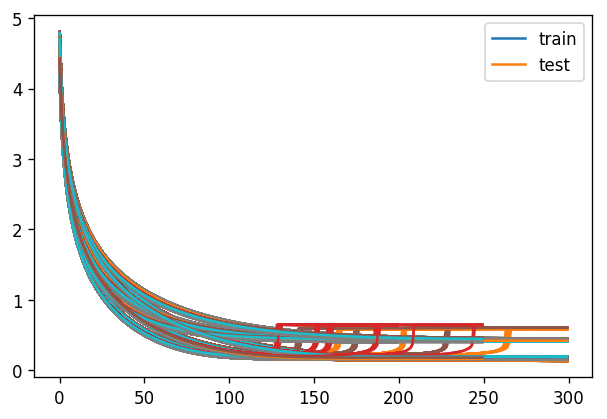

In [18]:
result = pd.DataFrame()
best_para = []
best_score = 1.0
for k in range(4,10):
    for epochs in [150,200,250,300]:
        for verbose_epoch in range(90,105):
            for learning_rate in range(3,6):
                for weight_decay in [0.0,0.1,0,15,0.2]:
                    train_loss, test_loss = k_fold_cross_valid(k, epochs, verbose_epoch, X_train,
                                                               y_train, learning_rate, weight_decay)
                    score = (train_loss + test_loss) / 2.0
                    result.append([{'k':k,'epochs':epochs,'verbose_epoch':verbose_epoch,\
                                  'learning_rate':learning_rate, 'weight_decay': weight_decay, 'score': score}])
                    if score < best_score:
                        best_score=score
                        best_para = [k, epochs, verbose_epoch, learning_rate, weight_decay]
                    print("paramters: k = %d, epochs = %d, verbose_epoch = %d, learning_rate = %d, weight_decay = %d"
                         %(k,epochs,verbose_epoch,learning_rate,weight_decay))
                    print("%d-fold validation: Avg train loss: %f, Avg test loss: %f \n" %(k, train_loss, test_loss))

print("best score = %d" %(best_score))
print(", with paramters:", best_para)

In [ ]:
result.head()

In [ ]:
#Kaggle submission

def learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate,
          weight_decay):
    net = get_net()
    train(net, X_train, y_train, None, None, epochs, verbose_epoch,
          learning_rate, weight_decay)
    preds = net(X_test).asnumpy()
    test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test['Id'], test['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    
#learn(epochs, verbose_epoch, X_train, y_train, test, learning_rate, weight_decay)   